# Лабораторная работа №3 по курсу “Компьютерная лингвистика”

#### Выполнил: студент группы 381703-4м Четвериков Антон

## Постановка задачи


Третья лабораторная работа направлена на практику работы с синтаксическими анализаторами. 

В работе предлагается провести работу по установлению влияния синтаксиса на индивидуальный авторский стиль. Выбранные Вами произведения должны быть проанализированы посредством синтаксического анализатора. После чего необходимо получить кумулятивные статистики по всему тексту и использовать их в качестве атрибутов для решения задачи кластеризации (методами K-means и иерархической кластеризацией).

Для работы в принципе можно использовать любой синтаксический анализатор, который был бы Вам удобен.
Однако, рекомендуется использовать библиотеку SpaCy. 

Требования к лабораторной работе:

* Выберете как минимум 4-5 авторов и как минимум 3 их произведения. 

* Авторы должны быть русскоязычными. 

* Проведите искусственное увеличение набора данных - для тех произведений, которые имеют достаточно большой объем “разбейте” их на несколько частей. Это необходимо чтобы увеличить объем данных. Предполагается, что стиль автора не меняется в течении произведения.

* Используя синтаксический анализатор, соберите статистику о рассматриваемом произведении. Составьте вектор атрибутов, который будет использоваться для решения задачи кластеризации. ВАЖНО: СОХРАНИТЕ ПОЛУЧИВШИЙСЯ ВЕКТОР АТРИБУТОВ!

* Выполните кластеризацию методом k-Means. Выполните  метод Elbow для определения оптимального количества кластеров и анализ силуэта. Выполните кластеризацию и выведете результаты.

* Насколько “чистой” получилась кластеризация? Какова “чистота” кластеризации? (Замечание: кластер чистый, если содержит в себе одних и тех же авторов - а это Вам известно).

* Постройте дендрограммы иерархической кластеризации. 

* Проинтерпретируйте, что Вы видите в результатах кластеризации и сделайте выводы.

Уточнение к пункту 3: Сделайте отдельно анализ с помощью treelets и параметров характеризующих рисунок дерева.
Сравните получившиеся результаты.

SpaCy помимо дерева зависимостей также проводит частеречной анализ (PoS-теггинг), поэтому использование частей речи может быть необходимым.

treelets

I Использование 
* В качестве базовых атрибутов предлагается использование т.н. treelets.

II Использование параметров, характеризующих рисунок дерева 
* Количество вершин дерева (соответствует количеству слов в предложении).
* Число уровней в дереве. Число уровней в дереве - это длина самого длинного из путей дерева.
* Ширина ветвления корня - число вершин, подчиненных корню.
* Максимальное количество перемен направления пути (зигзагов) в дереве. Учитывается два направления пути - левое и правое. Говорят, что путь на участке ai, ai+1 направлен налево, если вершина ai+1 расположена левее ai. Аналогично определяется правое направление.


In [1]:
import os

texts = {}

for writer in os.listdir(r"C:\books"):
    textNames = os.listdir(r"C:\books\\" + writer)
    texts.update({writer: textNames})

writers = list(texts.keys())

print(writers)

['Вадим Панов', 'Дмитрий Глуховский', 'Кир Булычев', 'Сергей Лукьяненко', 'Сергей Снегов']


Выводим список произведений по авторам:

In [2]:
print(texts)

{'Вадим Панов': ['Занимательная механика.txt', 'Ручной привод.txt', 'Таганский перекресток.txt'], 'Дмитрий Глуховский': ['Будущее.txt', 'Метро 2033.txt', 'Метро 2035.txt'], 'Кир Булычев': ['Девочка, с которой ничего не случится.txt', 'День рождения Алисы.txt', 'Путешествие Алисы.txt', 'Сто лет тому вперед.txt'], 'Сергей Лукьяненко': ['Звёзды - холодные игрушки.txt', 'Звездная тень.txt', 'Лабиринт отражений.txt'], 'Сергей Снегов': ['Вторжение в Персей.txt', 'Галактическая разведка.txt', 'Кольцо обратного времени.txt']}


Функция для разбиения входных текстов на части по n символов:

In [3]:
import itertools
def grouper(n, iterable):
    args = [iter(iterable)] * n
    return list("".join([e for e in t if e != None]) for t in itertools.zip_longest(*args))

Загружаем тексты:

In [51]:
data = []
label_list = []
for writer in writers:
    books = []
    for text in texts[writer]:
        with open(r"C:\books\\" + writer + "\\" + text) as bookFile:
            book = bookFile.read().replace('\n', ' ').replace('\xa0', ' ')
            for b in grouper(100000, book):
                books.append(b)
                label_list.append(writer + '_' + text[:-4])
    data.append(books)

Загрузка необходимых для работы с текстами модулей:

In [5]:
import spacy
nlp = spacy.load(r"C:\Users\anton\spacy-ru\ru2")

In [6]:
from nltk.tokenize import sent_tokenize

Разобьём по предложениям:

In [7]:
sent_tokenize_list = sent_tokenize(data[0][0])

Посмотрим на результат разделения по предложениям:

In [8]:
for sent_index, sent in enumerate(sent_tokenize_list[:50]):
    print("#{}:{}".format(sent_index, sent))

#0: Занимательная механика  Кто-то называл ее Богиней, кто-то – Золотой Бабой, но все жаждали встречи с ней, стремясь прикоснуться к Тайне.
#1:В непроходимых таежных дебрях ее искали посланцы Ивана Грозного, белые атаманы и красные комиссары, агенты спецслужб и тысячи безвестных охотников за удачей.
#2:Многие века пропадали без вести авантюристы, осмелившиеся прикоснуться к тайне золотого изваяния Великой Матери, но она открывалась лишь тем, кого выбирала сама.
#3:А в начале Третьего тысячелетия случилось то, что ранее казалось невозможным – Золотая Женщина покинула свое древнее убежище и очутилась в одном из самых циничных и совсем не волшебных городов мира – в Москве… И все это было только завязкой удивительной истории, в которой причудливо переплелись судьбы множества людей – от сыщиков экстра-класса до простых олигархов, приоткрылись многие тайны далекого и близкого прошлого, а главное, оказалось, что волшебниками не рождаются, ими становятся.
#4:Вернее, не волшебниками – Искусника

Напишем функцию, которая парсит по одному предложению и выводит некоторую информацию:

In [9]:
def parse_one_sentence(one_sentence):
    doc = nlp(one_sentence)
    for token in doc:
        print('{} \ {} \ {} \ {} \ {} \ {}'.format(
            token.text, 
            token.lemma_,
            token.pos_, 
            token.tag_, 
            token.dep_, 
            token.head.text
        ))

Теперь проведем анализ для каждого из предложений:

In [10]:
for sent_index, sent in enumerate(sent_tokenize_list[:5]):
    print("Sentence #{}\t{}".format(sent_index,sent))
    parse_one_sentence(sent)
    print('\n\n')

Sentence #0	 Занимательная механика  Кто-то называл ее Богиней, кто-то – Золотой Бабой, но все жаждали встречи с ней, стремясь прикоснуться к Тайне.
  \   \ SPACE \  \  \ Занимательная
Занимательная \ занимательный \ ADJ \ ADJ__Case=Nom|Degree=Pos|Gender=Fem|Number=Sing \ amod \ механика
механика \ механика \ NOUN \ NOUN__Animacy=Anim|Case=Nom|Gender=Fem|Number=Sing \ nsubj \ называл
  \   \ SPACE \  \  \ механика
Кто \ кто \ PRON \ PRON__Case=Nom \ appos \ механика
- \ - \ PUNCT \ PUNCT___ \ punct \ то
то \ то \ PART \ PART___ \ discourse \ Кто
называл \ называть \ VERB \ VERB__Aspect=Imp|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act \ ROOT \ называл
ее \ она \ PRON \ PRON__Case=Acc|Gender=Fem|Number=Sing|Person=3 \ det \ Богиней
Богиней \ богиней \ ADJ \ ADJ__Case=Dat|Degree=Pos|Gender=Fem|Number=Sing \ obl \ называл
, \ , \ PUNCT \ PUNCT___ \ punct \ кто
кто \ кто \ PRON \ PRON__Case=Nom \ conj \ называл
- \ - \ PUNCT \ PUNCT___ \ punct \ то
то \ то \ PART \ PAR

Женщина \ женщина \ NOUN \ NOUN__Animacy=Anim|Case=Nom|Gender=Fem|Number=Sing \ appos \ –
покинула \ покинуть \ VERB \ VERB__Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act \ conj \ случилось
свое \ свой \ DET \ DET__Case=Acc|Gender=Neut|Number=Sing \ det \ убежище
древнее \ древний \ ADJ \ ADJ__Case=Acc|Degree=Pos|Gender=Neut|Number=Sing \ amod \ убежище
убежище \ убежище \ NOUN \ NOUN__Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing \ obj \ покинула
и \ и \ CCONJ \ CCONJ___ \ cc \ очутилась
очутилась \ очутилась \ VERB \ VERB__Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Mid \ conj \ случилось
в \ в \ ADP \ ADP___ \ case \ одном
одном \ одном \ NUM \ NUM__Case=Loc|Gender=Masc \ nummod \ очутилась
из \ из \ ADP \ ADP___ \ case \ циничных
самых \ самых \ ADJ \ ADJ__Case=Gen|Degree=Pos|Number=Plur \ amod \ циничных
циничных \ циничный \ ADJ \ ADJ__Case=Gen|Degree=Pos|Number=Plur \ amod \ городов
и \ и \ CCONJ \ CCONJ___ \ cc \ волш

Используем одно из предложений:

In [11]:
sent_tokenize_list[353]

'Уезжали политики и бизнесмены, клерки и работяги, домохозяйки и мелкие лавочники, все, кто мог себе это позволить.'

Выводим семантическое дерево:

In [12]:
doc = nlp(sent_tokenize_list[353])

from nltk import Tree

def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_

to_nltk_tree(list(doc.sents)[0].root).pretty_print()

                                                     Уезжали                                    
                                                        |                                        
                                                     политики                                   
     ___________________________________________________|______________                          
    |        |       |          |              |                      все                       
    |        |       |          |              |                _______|___                      
    |        |       |          |              |               |          мог                   
    |        |       |          |              |               |    _______|___________          
бизнесмены клерки работяги домохозяйки     лавочники           |   |   |   |       позволить    
    |        |       |          |        ______|________       |   |   |   |    _______|______   
    и        ,       и   

Функция для получения атрибутов, характеризующих авторский стиль (число слов в предложении, число потомков корня, глубина семантического дерева)

In [13]:
def attr(doc):
    out = {'sentSize': len(doc)}
    for word in doc:
        if word.dep_ =='ROOT': out.update({'rootChild': len(list(word.children))})

    import json

    def depth(jsn):
        if 'modifiers' in jsn.keys():
            return 1 +  max([0] + list(map(depth, jsn['modifiers'])))
        else:
            return 1

    j = json.loads(str(doc.print_tree()[0]).replace('\'', "\""))
    out.update({'depthTree': depth(j)})
    return out

In [14]:
doc

Уезжали политики и бизнесмены, клерки и работяги, домохозяйки и мелкие лавочники, все, кто мог себе это позволить.

In [15]:
attr(doc)

{'depthTree': 6, 'rootChild': 1, 'sentSize': 22}

Вычисление числа встречающихся в тексте различных трилетов (используются топ-10 из наиболее встречаемых трилетов):

In [16]:
from itertools import combinations

def treelets(data, topN=10):
    one_gram_treelet = {}
    two_gram_treelet = {}
    three_gram_treelet = {}
    for sent in sent_tokenize(data):
        doc = nlp(sent)

        for token in doc:
            key = token.pos_
            one_gram_treelet.update({key: one_gram_treelet.get(key, 0) + 1})

            key = (token.head.pos_, token.dep_, token.pos_)
            two_gram_treelet.update({key: two_gram_treelet.get(key, 0) + 1})

            for (left_child, right_child) in combinations(token.children, 2):
                if left_child.dep_ != 'punct' and right_child.dep_ != 'punct':
                    key = (1, left_child.pos_, left_child.dep_, token.pos_, right_child.dep_, right_child.pos_)
                    three_gram_treelet.update({key: three_gram_treelet.get(key, 0) + 1})
            if token.dep_ != 'ROOT':
                for child in token.children:
                    if child.dep_ == 'punct' or token.dep_ == 'punct':
                        continue
                    key = (2, child.pos_, child.dep_, token.pos_, token.dep_, token.head.pos_)
                    three_gram_treelet.update({key: three_gram_treelet.get(key, 0) + 1})
                    
    import operator
    sorted_1gram_treelet = {}
    from collections import OrderedDict
    from operator import itemgetter
    sorted_1gram_treelet = dict((sorted(one_gram_treelet.items(), key=itemgetter(1)))[-topN:])  
    sorted_2gram_treelet = dict((sorted(two_gram_treelet.items(), key=itemgetter(1)))[-topN:])
    sorted_3gram_treelet = dict((sorted(three_gram_treelet.items(), key=itemgetter(1)))[-topN:])
    return (len(sent_tokenize(data)), sorted_1gram_treelet, sorted_2gram_treelet, sorted_3gram_treelet)

In [17]:
(numOfSents, sorted_1gram_treelet, sorted_2gram_treelet, sorted_3gram_treelet) = treelets(data[0][0])
print(numOfSents)
print(sorted_1gram_treelet)

1589
{'PROPN': 701, 'CCONJ': 783, 'PART': 848, 'PRON': 1035, 'ADV': 1046, 'ADP': 1491, 'ADJ': 1495, 'VERB': 2742, 'NOUN': 3634, 'PUNCT': 4566}


In [18]:
print(sorted_2gram_treelet)
print(list(sorted_2gram_treelet.keys()))

{('NOUN', 'nmod', 'NOUN'): 511, ('VERB', 'advmod', 'ADV'): 535, ('VERB', 'conj', 'VERB'): 577, ('VERB', 'nsubj', 'NOUN'): 599, ('NOUN', 'punct', 'PUNCT'): 634, ('NOUN', 'amod', 'ADJ'): 840, ('VERB', 'obl', 'NOUN'): 954, ('VERB', 'ROOT', 'VERB'): 1034, ('NOUN', 'case', 'ADP'): 1096, ('VERB', 'punct', 'PUNCT'): 2131}
[('NOUN', 'nmod', 'NOUN'), ('VERB', 'advmod', 'ADV'), ('VERB', 'conj', 'VERB'), ('VERB', 'nsubj', 'NOUN'), ('NOUN', 'punct', 'PUNCT'), ('NOUN', 'amod', 'ADJ'), ('VERB', 'obl', 'NOUN'), ('VERB', 'ROOT', 'VERB'), ('NOUN', 'case', 'ADP'), ('VERB', 'punct', 'PUNCT')]


In [19]:
print(sorted_3gram_treelet)

{(1, 'NOUN', 'nsubj', 'VERB', 'obl', 'NOUN'): 161, (1, 'CCONJ', 'cc', 'VERB', 'obl', 'NOUN'): 178, (2, 'ADJ', 'amod', 'NOUN', 'obl', 'VERB'): 205, (1, 'NOUN', 'nsubj', 'VERB', 'conj', 'VERB'): 231, (2, 'NOUN', 'obl', 'VERB', 'conj', 'VERB'): 236, (1, 'ADP', 'case', 'NOUN', 'amod', 'ADJ'): 252, (1, 'NOUN', 'obl', 'VERB', 'conj', 'VERB'): 256, (1, 'VERB', 'conj', 'VERB', 'conj', 'VERB'): 258, (2, 'CCONJ', 'cc', 'VERB', 'conj', 'VERB'): 271, (2, 'ADP', 'case', 'NOUN', 'obl', 'VERB'): 720}


In [20]:
import pickle

Анализ текстов по трилетам и сохранение полученных атрибутов для дальнейшего использования:

In [ ]:
trByAuth = []
for authorTexts in data:
    trByText = []
    for text in authorTexts:
        trByText.append(treelets(text))
    trByAuth.append(trByText)        
with open('dataTr.pickle', 'wb') as f:
    pickle.dump(trByAuth, f) 

In [21]:
with open('dataTr.pickle', 'rb') as f:
    trByAuth = pickle.load(f)

In [22]:
trAuth = []
for auth in trByAuth:
    trText = []
    for text in auth:
        numOfSent = 1
        numOfTreelets = list(map(lambda x: x/numOfSent, list(text[1].values()) + list(text[2].values()) + list(text[3].values())))
        trText.append(numOfTreelets)
    trAuth.append(trText)

K-Means кластеризация:

In [23]:
from sklearn.cluster import KMeans
Xtr = trAuth[0] + trAuth[1] + trAuth[2] + trAuth[3] + trAuth[4]

In [24]:
# костыль, у одного из списков не совпадает размер с остальными Т_Т
for lst in Xtr:
    if(len(lst) < 30):
        while(len(lst) < 30):
            lst.append(0)

Выбор оптимального числа классов:

In [25]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k).fit(Xtr)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

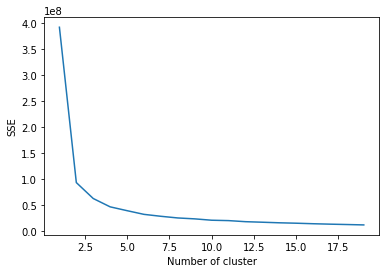

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Выберем число кластеров, равное 5 (по числу авторов):

In [27]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(Xtr)

Доля соответствия номера автора номеру кластера:

In [28]:
import numpy as np
matches = []
for Nclust in range(5):
    clustMatches = []
    for Nauth in range(5):
        authMatches = 0
        for i in kmeans.predict(np.array(trAuth[Nauth])):
            if i == Nclust: authMatches += 1
        clustMatches.append(authMatches/len(trAuth[Nauth]))
    matches.append(clustMatches)

Матрица соответствия номера кластера номеру автора, номера строк - номера кластеров, столбцов - авторов.
Столбец справа - номер столбца с максимальным значением (соответствует номеру автора, наиболее часто попадающего в данный кластер: 

In [29]:
for line in matches:
    for item in line:
        print("{:f}".format(item), end=' ')
    print(np.argmax(line), end='')
    print()

0.105263 0.000000 0.083333 0.000000 0.133333 4
0.000000 0.533333 0.166667 0.095238 0.000000 1
0.000000 0.300000 0.000000 0.047619 0.800000 4
0.052632 0.033333 0.250000 0.142857 0.066667 2
0.842105 0.133333 0.500000 0.714286 0.000000 0


Анализ текстов по атрибутам дерева, сохранение полученных атрибутов для дальнейшего использования:

In [ ]:
attrsByAuth = []
for authorTexts in data:
    attrsByText = []
    for text in authorTexts:
        sents = sent_tokenize(text)
        attrBySent = []
        for sent in sents:
            doc = nlp(sent)
            try:
                attrBySent.append(attr(doc))
            except:
                pass
        attrsByText.append(attrBySent)
    attrsByAuth.append(attrsByText)
    with open('data.pickle', 'wb') as f:
        pickle.dump(attrsByAuth, f)

In [30]:
with open('data.pickle', 'rb') as f:
    attrsByAuth = pickle.load(f)

Средние значения и СКО атрибутов по авторам (для первого текста):

In [31]:
import numpy as np
for i in range(5):
    depthTreeMean = np.mean([sent['depthTree'] for sent in attrsByAuth[i][0]])
    depthTreeStd = np.std([sent['depthTree'] for sent in attrsByAuth[i][0]])
    print(depthTreeMean, depthTreeStd)

3.8410852713178296 1.610468614442231
3.7966197183098593 1.6236942261068978
3.660300136425648 1.399870747283324
3.7436323366555926 1.381394678561367
4.026902382782475 1.476450658233198


Усреднение атрибутов по всем текстам каждого из авторов:

In [32]:
aAuth = []
for auth in attrsByAuth:
    aText = []
    for text in auth:
        x = [0,0,0]
        n = len(text)
        for sent in text:
            x[0] += sent['depthTree'] / n
            x[1] += sent['rootChild'] / n
            x[2] += sent['sentSize'] / n
        aText.append(x)
    aAuth.append(aText)

K-Means кластеризация:

In [33]:
X = np.array(aAuth[0] + aAuth[1] + aAuth[2] + aAuth[3] + aAuth[4])

Выбор оптимального числа классов:

In [34]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k).fit(X)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

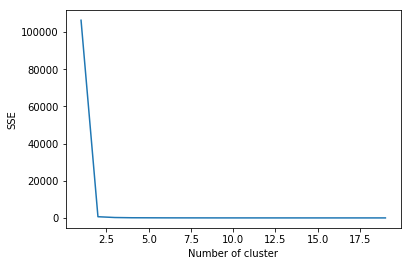

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [36]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

Доля соответствия номера автора номеру кластера:

In [37]:
matches = []
for Nclust in range(5):
    clustMatches = []
    for Nauth in range(5):
        authMatches = 0
        for i in kmeans.predict(np.array(aAuth[Nauth])):
            if i == Nclust: authMatches += 1
        clustMatches.append(authMatches/len(aAuth[Nauth]))
    matches.append(clustMatches)

Матрица соответствия номера кластера номеру автора, номера строк - номера кластеров, столбцов - авторов. Столбец справа - номер столбца с максимальным значением (соответствует номеру автора, наиболее часто попадающего в данный кластер:

In [38]:
for line in matches:
    for item in line:
        print("{:f}".format(item), end=' ')
    print(np.argmax(line), end='')
    print()

0.052632 0.233333 0.166667 0.047619 0.000000 1
0.000000 0.000000 0.000000 0.047619 0.000000 3
0.157895 0.133333 0.000000 0.047619 1.000000 4
0.000000 0.300000 0.000000 0.000000 0.000000 1
0.789474 0.333333 0.833333 0.857143 0.000000 3


Аналогичная кластеризация без усреднения по предложениям:

In [39]:
aAuthL = []
for auth in attrsByAuth:
    aText = []
    for text in auth:
        for sent in text:
            aText.append([ sent['depthTree'], sent['rootChild'], sent['sentSize'] ])
    aAuthL.append(aText)

In [40]:
XL = np.array(aAuthL[0] + aAuthL[1] + aAuthL[2] + aAuthL[3] + aAuthL[4])

Выбор оптимального числа классов:

In [41]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k).fit(XL)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

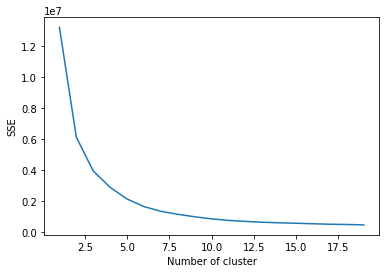

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [43]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(XL)

Доля соответствия номера автора номеру кластера:

In [44]:
matches = []
for Nclust in range(5):
    clustMatches = []
    for Nauth in range(5):
        authMatches = 0
        for i in kmeans.predict(np.array(aAuth[Nauth])):
            if i == Nclust: authMatches += 1
        clustMatches.append(authMatches/len(aAuth[Nauth]))
    matches.append(clustMatches)

Матрица соответствия номера кластера номеру автора, номера строк - номера кластеров, столбцов - авторов. Столбец справа - номер столбца с максимальным значением (соответствует номеру автора, наиболее часто попадающего в данный кластер:

In [45]:
for line in matches:
    for item in line:
        print("{:f}".format(item), end=' ')
    print(np.argmax(line), end='')
    print()

1.000000 0.700000 1.000000 0.952381 1.000000 0
0.000000 0.166667 0.000000 0.000000 0.000000 1
0.000000 0.000000 0.000000 0.000000 0.000000 0
0.000000 0.000000 0.000000 0.047619 0.000000 3
0.000000 0.133333 0.000000 0.000000 0.000000 1


In [46]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [47]:
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

Построение матрицы связи:

In [48]:
Z = linkage(Xtr, 'ward')

In [49]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(Xtr))
c

0.9260260331600106

Построение полной дендрограммы:

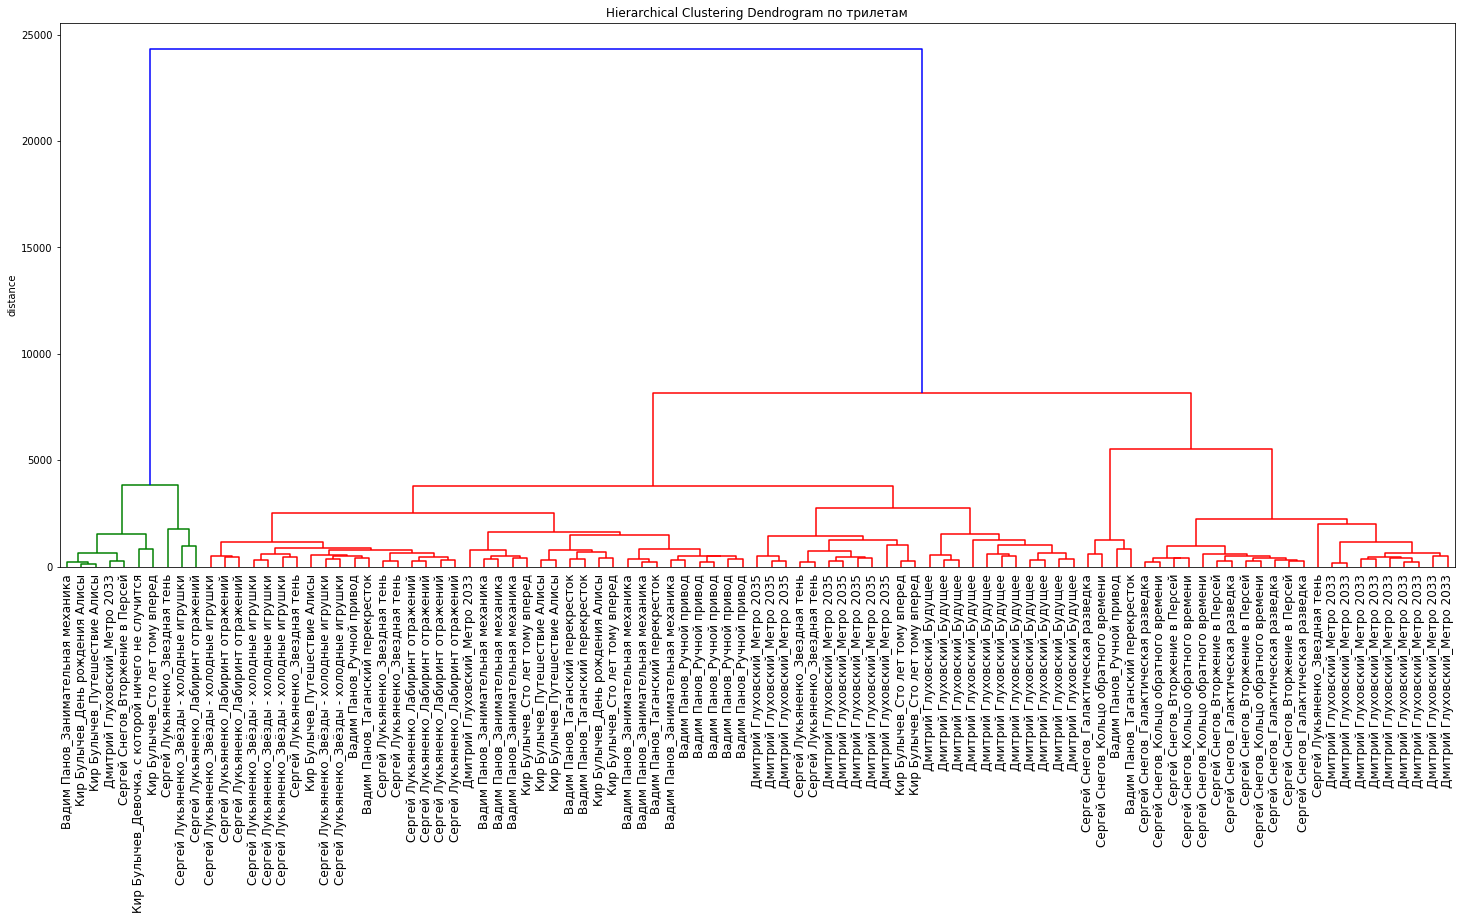

In [52]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram по трилетам')
plt.ylabel('distance')
dendrogram(
    Z,
    labels=label_list,
    leaf_rotation=90.,
    leaf_font_size=12.,
)
plt.show()

In [53]:
Z = linkage(X, 'ward')
c, coph_dists = cophenet(Z, pdist(X))
c

0.9942346700809257

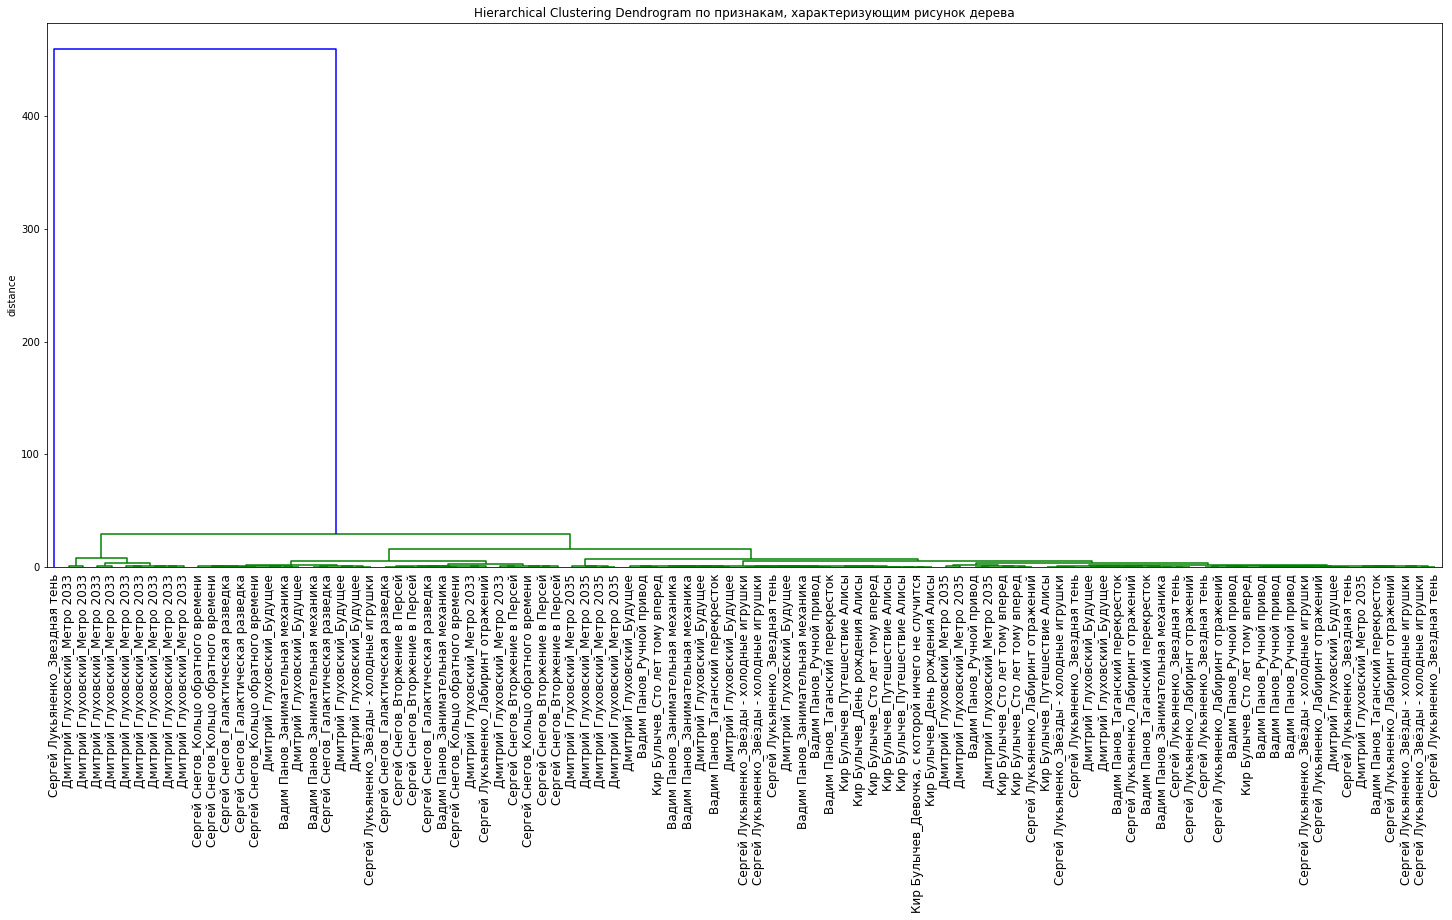

In [54]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram по признакам, характеризующим рисунок дерева')
plt.ylabel('distance')
dendrogram(
    Z,
    labels=label_list,
    leaf_rotation=90.,
    leaf_font_size=12.,
)
plt.show()

Вывод: чистых кластеров не наблюдается, кластеризация по авторам предложенным методом имеет невысокую точность